# Transport patterns between curves
The goal of this notebook is to visualize transport patterns between
curves; it appears that the linear program may be the bottleneck of
the implementation, so we're going to see if we can write a more efficient
implementation here.

First, we'll define some curves.

In [502]:
# imports
import numpy as np
import numpy.linalg as la
import scipy.optimize as op
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt

%load_ext line_profiler
%matplotlib inline

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## Define (and plot) the line segments

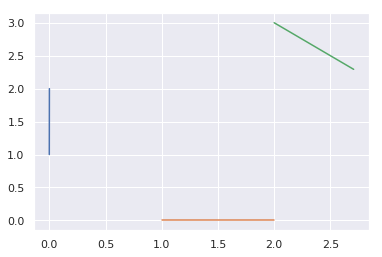

In [579]:
def line_segment(start, vec, seglen, n_pts):
    p0 = np.array(start)
    v = np.array(vec)
    v = v / la.norm(v) * seglen / n_pts
    return np.array([p0+k*v for k in range(n_pts+1)])

def random_uniform_direction():
    theta = np.random.uniform(0, 2*np.pi)
    return [np.cos(theta), np.sin(theta)]

N_DIV = 30
N_CURVE = 3
RMAX = 2.
curves = [
    line_segment(np.random.uniform(0, RMAX, size=2), 
                 random_uniform_direction(), 1, N_DIV-1),
    line_segment(np.random.uniform(0, RMAX, size=2), 
                 random_uniform_direction(), 1, N_DIV-1),
    line_segment(np.random.uniform(0, RMAX, size=2), 
                 random_uniform_direction(), 1, N_DIV-1)
]
curves = [
    line_segment((0,1), 
                 (0.001,1), 1, N_DIV-1),
    line_segment((1,0), 
                 (1,0), 1, N_DIV-1),
    line_segment((2,3), 
                 (1,-1), 1, N_DIV-1)
]

for curve in curves:
    sns.lineplot(*curve.T, antialiased=True)
    #sns.scatterplot(*curve.T, antialiased=True)
plt.show()

## Geometric median function

In [580]:
# Geometric median
import numpy as np
from scipy.spatial.distance import cdist, euclidean
import numpy.linalg as la

def geometric_median(X, eps=1e-5, max_iter=1000):
    y = np.mean(X, 0)

    for _ in range(max_iter):
        D = cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if euclidean(y, y1) < eps:
            return y1

        y = y1
    return y

th60 = np.radians(60)
c60, s60 = np.cos(th60), np.sin(th60)
rot60 = np.array([[c60,-s60],[s60,c60]])
rotN60 = np.array([[c60,s60],[-s60,c60]])

def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

def get_intersect_many(s):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    #s = np.vstack([a1,a2,b1,b2])        # s for stacked
    #print(s.shape)
    h = np.concatenate((s, np.ones((s.shape[0], 4, 1))), axis=2) # h for homogeneous
    #print(h.shape)
    
    l1 = np.cross(h[:,0], h[:,1])           # get first line
    l2 = np.cross(h[:,2], h[:,3])           # get second line
    x, y, z = np.cross(l1, l2).T          # point of intersection
#    if z == 0:                          # lines are parallel
#        return (float('inf'), float('inf'))
    
    return np.array((x/z, y/z))

def geometric_median_3(X, **kwargs):
    """Use geometry to compute fast explicit GM of 3 points"""
    A,B,C = X
    
    ABvec = B-A
    ACvec = C-A
    if (np.arctan2(ACvec[1], ACvec[0]) - np.arctan2(ABvec[1], ABvec[0])) > 0:
        B,C = C,B
        ABvec = B-A
        ACvec = C-A
    
    ARvec = rot60 @ ABvec
    R = X[0]+ARvec
    
    AQvec = rotN60 @ ACvec
    Q = X[0]+AQvec
    
    P = get_intersect(R,X[2],Q,X[1])
    
    S = [A,B,C,P]
    d = [sum(la.norm(z-fp) for z in X) for fp in S]
    
    return S[np.argmin(d)]
    

## Set up the linear program

In [581]:
#%%timeit

N = len(curves[0])

ABmtx = np.zeros([N,N,2])
import itertools

for (ai, a), (bi, b) in itertools.product(enumerate(curves[0]), enumerate(curves[1])):
    ABmtx[ai,bi,:] = b-a
    
ARmtx = np.tensordot(ABmtx, rot60, (2,1))

ACmtx = np.zeros([N,N,2])

for (ai, a), (ci, c) in itertools.product(enumerate(curves[0]), enumerate(curves[2])):
    ACmtx[ai,ci,:] = c-a
    
AQmtx = np.tensordot(ACmtx, rotN60, (2,1))

Betamtx = np.arctan2(ACmtx[:,:,1],ACmtx[:,:,0])
Gammamtx = np.arctan2(ABmtx[:,:,1],ABmtx[:,:,0])

In [731]:
#%%timeit

import math, itertools

def f():
# Specific 3-group case
    groups = []
    
    for i0, A in enumerate(curves[0]):    
        #batch = np.zeros((len(curves[1])*len(curves[2]), 4, 2))
        batch = []
        index = []
        
        # matrix of angles
        phimtx = Betamtx[i0,:] - Gammamtx[i0,:,np.newaxis]
        pmamtx = (1.*(phimtx < 0))[:,:,np.newaxis]
        
        AR = np.broadcast_to(ARmtx[i0,:,np.newaxis], (30,30,2))
        AQ = np.broadcast_to(AQmtx[i0,np.newaxis], (30,30,2))
        
        AA = np.broadcast_to(A, (30,30,2))
        BB = np.broadcast_to(curves[1][:,np.newaxis], (30,30,2))
        CC = np.broadcast_to(curves[2][np.newaxis], (30,30,2))
        
        #AR = (
        #    ((A + ARmtx[i0,:])[np.newaxis] + np.ones((len(curves[2]),1,2))) * pmamtx[:,:,np.newaxis] +
        #    ((curves[1] + ARmtx[i0,:])[np.newaxis] + np.ones((len(curves[2]),1,2))) * (1-pmamtx)[:,:,np.newaxis]
        #)
        
        RR = (AA+AR)*pmamtx + (BB-AR)*(1-pmamtx)
        QQ = (AA+AQ)*pmamtx + (CC-AQ)*(1-pmamtx)

        K = len(curves[0])
        
        index = itertools.product(range(K), range(K))
                
        Batch = np.stack([RR,CC,QQ,BB], axis=2)
        batch = np.reshape(Batch, (K*K,4,2))
                
        #batch = np.array(batch)
        Pvec = get_intersect_many(batch).T
            
        Sb = np.zeros((batch.shape[0], 4, 2))
        Sb[:,0] = A
        Sb[:,1] = batch[:,3]
        Sb[:,2] = batch[:,1]
        Sb[:,3] = Pvec

        Zb = Sb[:,0:3,:]

        Evec = np.sum(
            la.norm(Sb[:,:,np.newaxis]-Zb[:,np.newaxis], axis=-1),
            axis=2
        )
        #print(Evec)

        minvec = np.argmin(Evec, axis=1)

        for (i1,i2), (R,C,Q,B), P, S, energy, m_i in (zip(index, batch, Pvec, Sb, Evec, minvec)):
            groups.append({
                'index': [i0, i1, i2],
                #'points': np.array([A,B,C]),
                'median': S[m_i],
                'energy': energy[m_i],
            })

    return groups


In [732]:
np.broadcast_to(ARmtx[0,:,np.newaxis], (30,30,2))
np.broadcast_to(AQmtx[0,np.newaxis], (30,30,2))[0,:]
np.broadcast_to(curves[2][np.newaxis], (30,30,2))[0,:]

array([[2.        , 3.        ],
       [2.02438299, 2.97561701],
       [2.04876598, 2.95123402],
       [2.07314898, 2.92685102],
       [2.09753197, 2.90246803],
       [2.12191496, 2.87808504],
       [2.14629795, 2.85370205],
       [2.17068095, 2.82931905],
       [2.19506394, 2.80493606],
       [2.21944693, 2.78055307],
       [2.24382992, 2.75617008],
       [2.26821292, 2.73178708],
       [2.29259591, 2.70740409],
       [2.3169789 , 2.6830211 ],
       [2.34136189, 2.65863811],
       [2.36574489, 2.63425511],
       [2.39012788, 2.60987212],
       [2.41451087, 2.58548913],
       [2.43889386, 2.56110614],
       [2.46327686, 2.53672314],
       [2.48765985, 2.51234015],
       [2.51204284, 2.48795716],
       [2.53642583, 2.46357417],
       [2.56080883, 2.43919117],
       [2.58519182, 2.41480818],
       [2.60957481, 2.39042519],
       [2.6339578 , 2.3660422 ],
       [2.6583408 , 2.3416592 ],
       [2.68272379, 2.31727621],
       [2.70710678, 2.29289322]])

In [733]:
mask = np.array([0,0,1,0])
c = np.array([4,4,4,4])

In [734]:
%lprun -f f -f get_intersect_many groups=f()

Timer unit: 1e-06 s

Total time: 0.059161 s
File: <ipython-input-580-6f5d99771b0b>
Function: get_intersect_many at line 57

Line #      Hits         Time  Per Hit   % Time  Line Contents
    57                                           def get_intersect_many(s):
    58                                               """ 
    59                                               Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    60                                               a1: [x, y] a point on the first line
    61                                               a2: [x, y] another point on the first line
    62                                               b1: [x, y] a point on the second line
    63                                               b2: [x, y] another point on the second line
    64                                               """
    65                                               #s = np.vstack([a1,a2,b1,b2])        # s for stacked
    66   

Initial implementation runtime was

     11.7 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     
After adding a few preprocess steps new time is...

     11.6 s ± 50.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     
No on-the-fly arctan gives...

     11.3 s ± 66.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     
Preprocess rotate gives...

     11.2 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
     


In [735]:
medians = np.array([g['median'] for g in groups])

In [736]:
#pd.DataFrame(groups)

We now move on to setting up (and solving) the linear program proper. Scipy's linprog uses the following form for linear programs. We are solving for \\(x\\) which minimizes
\\[ c^T x \\]
while satisfying the constraints
\\[ A_{ub} x \le b_{ub}, \quad A_{eq} x = b_{eq}, \quad l \le x \le u \\]

In our case, the cost we're minimizing is the linear combination of total median distances

In [737]:
# group energies (c-vector)
energies = np.array([g['energy'] for g in groups])

In [ ]:
def _idxs(index):
    return [i*N_DIV+j for i,j in enumerate(index)]

import scipy.sparse as sparse

# equality constraints
A_eq = sparse.dok_matrix((N_DIV*N_CURVE, len(energies)))
for i,g in enumerate(groups):
    A_eq[_idxs(g['index']), i] = 1.
    
# transport quantities are all 1 for uniform problem
b_eq = np.ones(A_eq.shape[0])

In [ ]:
A_eq.shape

In [ ]:
from scipy.optimize import linprog
soln = linprog(energies, A_eq=A_eq, b_eq=b_eq, method='interior-point')

In [ ]:
import pandas as pd
solution = pd.DataFrame([
    {'weight': x, 
     'median_x': group['median'][0], 
     'median_y': group['median'][1],
     't_0': group['index'][0],
     't_1': group['index'][1],
     't_2': group['index'][2]} for 
    x,group in zip(soln['x'], groups)])

print(len(solution[solution['weight'] > 0.001]), "median points")
solution[solution['weight'] > 0.001].sort_values('t_2')

In [ ]:
for curve in curves:
    sns.lineplot(*curve.T, antialiased=True)
    #sns.scatterplot(*curve.T, antialiased=True)
    
g = sns.scatterplot(data=solution[solution['weight'] > 1e-3], 
                x='median_x', y='median_y',
                hue='t_2', size='weight', size_norm=(0,1))
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

In [ ]:
for curve in curves:
    sns.lineplot(*curve.T, antialiased=True)
    #sns.scatterplot(*curve.T, antialiased=True)
    
g = sns.scatterplot(data=solution, 
                x='median_x', y='median_y',
                hue='t_2')
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

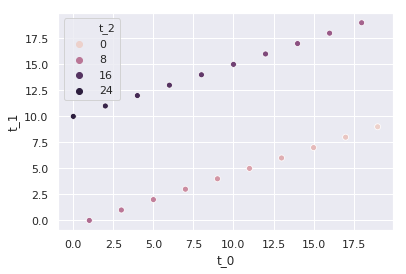

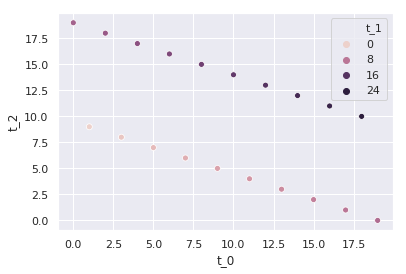

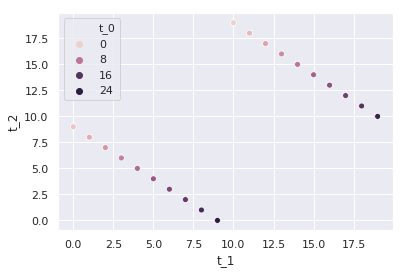

In [555]:
import itertools

sets = ['t_0', 't_1', 't_2']

for x,y,z in [['t_0', 't_1', 't_2'], ['t_0', 't_2', 't_1'], ['t_1', 't_2', 't_0']]:
    sns.scatterplot(data=solution[solution['weight'] > 1e-3], x=x, y=y, hue=z)
    plt.show()

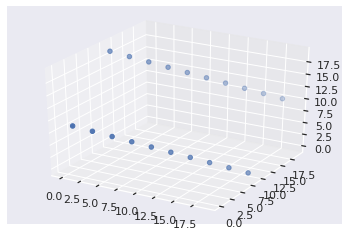

In [556]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

psol = solution[solution['weight'] > 1e-3]
ax.scatter(psol['t_0'], psol['t_1'], psol['t_2'])

fig.show()